In [14]:
%pip install neuralforecast


Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from neuralforecast.losses.pytorch import MAE
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl

In [12]:
# Custom callback to save training losses at each epoch
class SaveTrainingLossCallback(pl.Callback):
    def __init__(self, log_file='epoch_loss_log_window_itransformer_model_six_months_nifty_weekly.txt'):
        self.training_losses = []
        self.log_file = log_file
        self.window_number = 0
        with open(self.log_file, 'w') as f:
            f.write('Epoch,Train_Loss,Window\n')

    def on_train_epoch_end(self, trainer, pl_module):
        # Save the training loss at the end of each epoch
        train_loss = trainer.callback_metrics['train_loss'].item()
        self.training_losses.append(train_loss)
        print(f"Epoch {trainer.current_epoch}: Train Loss = {train_loss}")
        
        # Log the loss to the file
        with open(self.log_file, 'a') as f:
            f.write(f'{trainer.current_epoch},{train_loss},{self.window_number}\n')

    def set_window_number(self, window_number):
        self.window_number = window_number

# Initialize callbacks
save_loss_callback = SaveTrainingLossCallback()
pl_trainer_kwargs = {"callbacks": [save_loss_callback], "accelerator": "cpu", "devices": 1}

In [13]:

# Load and preprocess the data
csv_file_path = '/home/raj/Rajarshi/Term Project/notebook_files/data/^NSEI_week.csv'
data = pd.read_csv(csv_file_path, parse_dates=['Date'])
data.dropna(inplace=True)
data.set_index('Date', inplace=True)
data = data.asfreq('B', method='pad')

# Create scalers
scaler_close = MinMaxScaler()
data['Open_Close_Diff'] = data['Open'] - data['Close']
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Initialize variables
training_end_date = data.index.max() - pd.DateOffset(months=6)  # Train using last 1 year of data
final_predictions = []



In [14]:
# Define the window management and model training class
class ModelTrainer:
    def __init__(self, data, scaler_close, save_loss_callback, pl_trainer_kwargs):
        self.data = data
        self.scaler_close = scaler_close
        self.save_loss_callback = save_loss_callback
        self.pl_trainer_kwargs = pl_trainer_kwargs

    def train_model(self, train_data, window_number):
        # Set the window number for the callback
        self.save_loss_callback.set_window_number(window_number)

        # Prepare the training data
        Y_train_df = train_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
        # Y_train_df['unique_id'] = 'SBIN'
        Y_train_df['unique_id'] = 'NSEI'

        # Initialize and train the iTransformer model
        model = iTransformer(
            h=7,  # Output horizon (prediction length)
            input_size=60,  # Input window size
            n_series=1,  # Number of time series (SBIN in this case)
            hidden_size=512,  # Adjusted for iTransformer
            n_heads=8,
            e_layers=2,
            d_layers=1,
            d_ff=2048,
            factor=1,
            dropout=0.1,
            use_norm=True,
            loss=MAE(),
            learning_rate=0.001,
            max_steps=500,  # Adjusted as per your code
            **{'callbacks': [self.save_loss_callback]}  # Pass the callback directly here
        )

        # NeuralForecast object to handle model training
        nf = NeuralForecast(models=[model], freq='B')
        nf.fit(df=Y_train_df)

        # Generate future dataframe automatically
        futr_df = nf.make_future_dataframe()

        # Generate predictions
        forecasts = nf.predict(futr_df=futr_df)
        
        pred_values = self.scaler_close.inverse_transform(forecasts[['iTransformer']].values)
        dates = futr_df['ds']

        return dates, pred_values


In [15]:
# Initialize the trainer
trainer = ModelTrainer(data, scaler_close, save_loss_callback, pl_trainer_kwargs)

# Training and prediction loop
window_number = 1
while True:
    train_data = data.loc[:training_end_date]
    print(f"Training window {window_number}: from {train_data.index.min()} to {train_data.index.max()}")

    # Train the model and get predictions
    dates, pred_values = trainer.train_model(train_data, window_number)

    if len(dates) == 0:
        print("No future dates were generated. Exiting the loop.")
        break

    # Store the predictions
    predictions_df = pd.DataFrame({'Date': dates, 'Predicted Value': pred_values.flatten()})
    final_predictions.append(predictions_df)

    # Update training_end_date for the next window only if dates exist
    training_end_date = dates.iloc[-1] if len(dates) > 0 else training_end_date

    # Break if we reach the end of the data
    if training_end_date >= data.index.max():
        break

    window_number += 1

Seed set to 1


Training window 1: from 2008-05-12 00:00:00 to 2022-06-30 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s, v_num=320, train_loss_step=0.013, train_loss_epoch=0.013] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, v_num=320, train_loss_step=0.013, train_loss_epoch=0.013]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 2: from 2008-05-12 00:00:00 to 2022-07-11 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s, v_num=326, train_loss_step=0.00928, train_loss_epoch=0.00928]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s, v_num=326, train_loss_step=0.00928, train_loss_epoch=0.00928]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 3: from 2008-05-12 00:00:00 to 2022-07-20 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s, v_num=330, train_loss_step=0.011, train_loss_epoch=0.011] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, v_num=330, train_loss_step=0.011, train_loss_epoch=0.011]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s] 

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      |


Training window 4: from 2008-05-12 00:00:00 to 2022-07-29 00:00:00
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, v_num=334, train_loss_step=0.0106, train_loss_epoch=0.0106] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, v_num=334, train_loss_step=0.0106, train_loss_epoch=0.0106]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training window 5: from 2008-05-12 00:00:00 to 2022-08-09 00:00:00



  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
-----------------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.362    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s, v_num=338, train_loss_step=0.00859, train_loss_epoch=0.00859]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s, v_num=338, train_loss_step=0.00859, train_loss_epoch=0.00859]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.36it/s] 

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      |


Training window 6: from 2008-05-12 00:00:00 to 2022-08-18 00:00:00
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s, v_num=342, train_loss_step=0.00808, train_loss_epoch=0.00808]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s, v_num=342, train_loss_step=0.00808, train_loss_epoch=0.00808]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.17it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      |


Training window 7: from 2008-05-12 00:00:00 to 2022-08-29 00:00:00
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, v_num=346, train_loss_step=0.0113, train_loss_epoch=0.0113] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s, v_num=346, train_loss_step=0.0113, train_loss_epoch=0.0113]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 8: from 2008-05-12 00:00:00 to 2022-09-07 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s, v_num=350, train_loss_step=0.00914, train_loss_epoch=0.00914]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, v_num=350, train_loss_step=0.00914, train_loss_epoch=0.00914]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 9: from 2008-05-12 00:00:00 to 2022-09-16 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s, v_num=354, train_loss_step=0.0122, train_loss_epoch=0.0122]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, v_num=354, train_loss_step=0.0122, train_loss_epoch=0.0122]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.83it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training window 10: from 2008-05-12 00:00:00 to 2022-09-27 00:00:00



  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
-----------------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.362    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, v_num=358, train_loss_step=0.00834, train_loss_epoch=0.00834]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, v_num=358, train_loss_step=0.00834, train_loss_epoch=0.00834]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training window 11: from 2008-05-12 00:00:00 to 2022-10-06 00:00:00



  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
-----------------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.362    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=362, train_loss_step=0.00755, train_loss_epoch=0.00755]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s, v_num=362, train_loss_step=0.00755, train_loss_epoch=0.00755]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.85it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 12: from 2008-05-12 00:00:00 to 2022-10-17 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s, v_num=365, train_loss_step=0.0129, train_loss_epoch=0.0129] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s, v_num=365, train_loss_step=0.0129, train_loss_epoch=0.0129]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.93it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 13: from 2008-05-12 00:00:00 to 2022-10-26 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s, v_num=367, train_loss_step=0.00826, train_loss_epoch=0.00826]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s, v_num=367, train_loss_step=0.00826, train_loss_epoch=0.00826]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.39it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 14: from 2008-05-12 00:00:00 to 2022-11-04 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s, v_num=369, train_loss_step=0.0115, train_loss_epoch=0.0115] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s, v_num=369, train_loss_step=0.0115, train_loss_epoch=0.0115]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.06it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 15: from 2008-05-12 00:00:00 to 2022-11-15 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, v_num=371, train_loss_step=0.00676, train_loss_epoch=0.00676]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=371, train_loss_step=0.00676, train_loss_epoch=0.00676]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.04it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 16: from 2008-05-12 00:00:00 to 2022-11-24 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, v_num=373, train_loss_step=0.0117, train_loss_epoch=0.0117] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s, v_num=373, train_loss_step=0.0117, train_loss_epoch=0.0117]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.15it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 17: from 2008-05-12 00:00:00 to 2022-12-05 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=375, train_loss_step=0.0114, train_loss_epoch=0.0114] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s, v_num=375, train_loss_step=0.0114, train_loss_epoch=0.0114]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.73it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 18: from 2008-05-12 00:00:00 to 2022-12-14 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s, v_num=377, train_loss_step=0.010, train_loss_epoch=0.010] 

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s, v_num=377, train_loss_step=0.010, train_loss_epoch=0.010]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 1



Training window 19: from 2008-05-12 00:00:00 to 2022-12-23 00:00:00


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MAE                    | 0      | train
1 | padder        | ConstantPad1d          | 0      | train
2 | scaler        | TemporalNorm           | 0      | train
3 | enc_embedding | DataEmbedding_inverted | 31.2 K | train
4 | encoder       | TransEncoder           | 6.3 M  | train
5 | projector     | Linear                 | 3.6 K  | train
----------------------------

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s, v_num=379, train_loss_step=0.0106, train_loss_epoch=0.0106]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, v_num=379, train_loss_step=0.0106, train_loss_epoch=0.0106]

/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.54it/s]


/home/raj/Rajarshi/Term Project/notebook_files/tpvenv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [16]:
# Combine predictions and save
all_predictions_df = pd.concat(final_predictions, ignore_index=True)
output_csv_file = 'prediction_using_window_method_itransformer_model_six_months_nifty_weekly.csv'
all_predictions_df.to_csv(output_csv_file, index=False)

print(f"Predictions saved to {output_csv_file}")

# Print the logged training losses
print("Training Losses:", save_loss_callback.training_losses)


Predictions saved to prediction_using_window_method_itransformer_model_six_months_nifty_weekly.csv
Training Losses: []


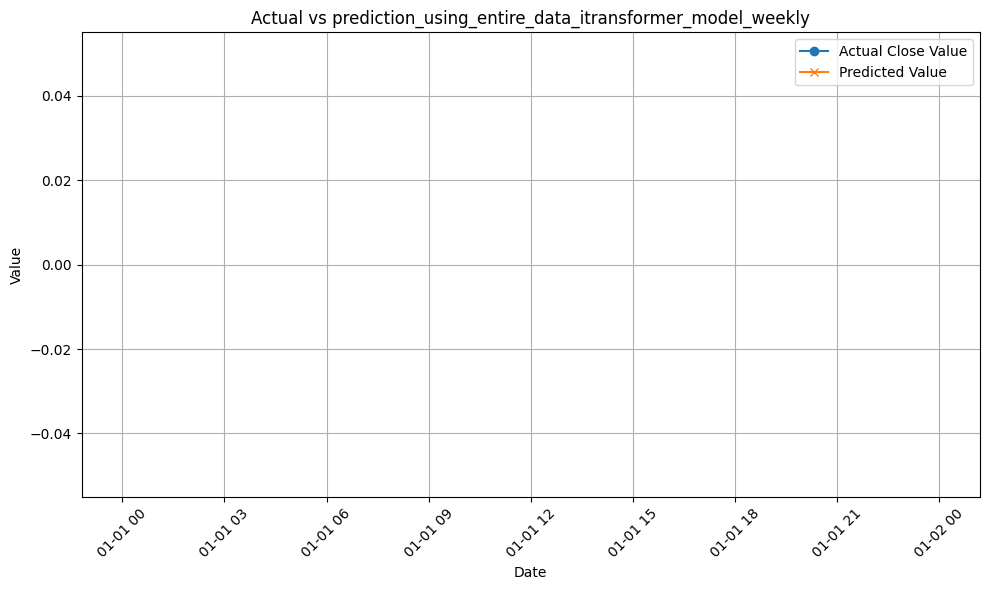

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

# Load the actual data from the CSV file
#actual_csv_path = '/home/raj/Rajarshi/Term Project/notebook_files/data/SBIN.NS_day_2023.csv'
actual_csv_path = csv_file_path
actual_df = pd.read_csv(actual_csv_path)

# Load the predicted data from the CSV file
#predicted_csv_path = '/home/raj/Rajarshi/Term Project/rajarshi_code/itransformer_file/prediction_using_entire_data_itransformer_model.csv'
predicted_csv_path = output_csv_file
predicted_df = pd.read_csv(predicted_csv_path)

# Convert the 'Date' columns to a consistent datetime format for both DataFrames
actual_df['Date'] = pd.to_datetime(actual_df['Date'], errors='coerce')
predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], errors='coerce')

# Drop rows with invalid dates (NaT)
actual_df = actual_df.dropna(subset=['Date'])
predicted_df = predicted_df.dropna(subset=['Date'])

# Merge the DataFrames on the 'Date' column, keeping only the matching dates
merged_df = pd.merge(predicted_df, actual_df, on='Date', how='inner')

# Print the matched dates for verification
# print("Matched Dates:\n", merged_df['Date'])

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Actual Close Value', marker='o')
plt.plot(merged_df['Date'], merged_df['Predicted Value'], label='Predicted Value', marker='x')

# If 'Window Start' and 'Window End' columns are present, add vertical markers
if 'Window Start' in predicted_df.columns and 'Window End' in predicted_df.columns:
    for i in range(len(predicted_df)):
        plt.axvline(predicted_df['Window Start'].iloc[i], color='green', linestyle='--', label='Window Start' if i == 0 else '')
        plt.axvline(predicted_df['Window End'].iloc[i], color='red', linestyle='--', label='Window End' if i == 0 else '')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
title = 'Actual vs prediction_using_entire_data_itransformer_model_weekly'
plt.title(title)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()

# Specify the folder where you want to save the plot
output_folder = '/home/raj/Rajarshi/Term Project/notebook_files/saved_plots/'

# Ensure the folder exists, if not, create it
os.makedirs(output_folder, exist_ok=True)

# Use the plot title for the filename, replacing spaces with underscores and converting to lowercase
filename = f'{title.replace(" ", "_").lower()}.png'

# Save the plot in the specified folder with the generated filename
plt.savefig(os.path.join(output_folder, filename), format='png', dpi=300)

# Show the plot
plt.show()